In [1]:
import json
import os
import shutil
from datetime import datetime, timedelta

import numpy as np
import strax
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4

import helix as hx
from helix import units
import strax as sx                    
import numba
import pandas as pd
import scipy as sp
import sys
import os
import shutil
from glob import glob
from matplotlib import pyplot as plt

run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata




In [2]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                  | 0.00 % [00:00<?], #1 (0.34 s). 384.0 MB/s


(9, 50, 32768)

In [3]:
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type

/Users/wongdowling/Documents/helix/helix/optimum_filter.py:95: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:95: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD 

ValueError: In the OF, traces length 0 must be equal to the template length (32768).

NameError: name 'fit_results' is not defined

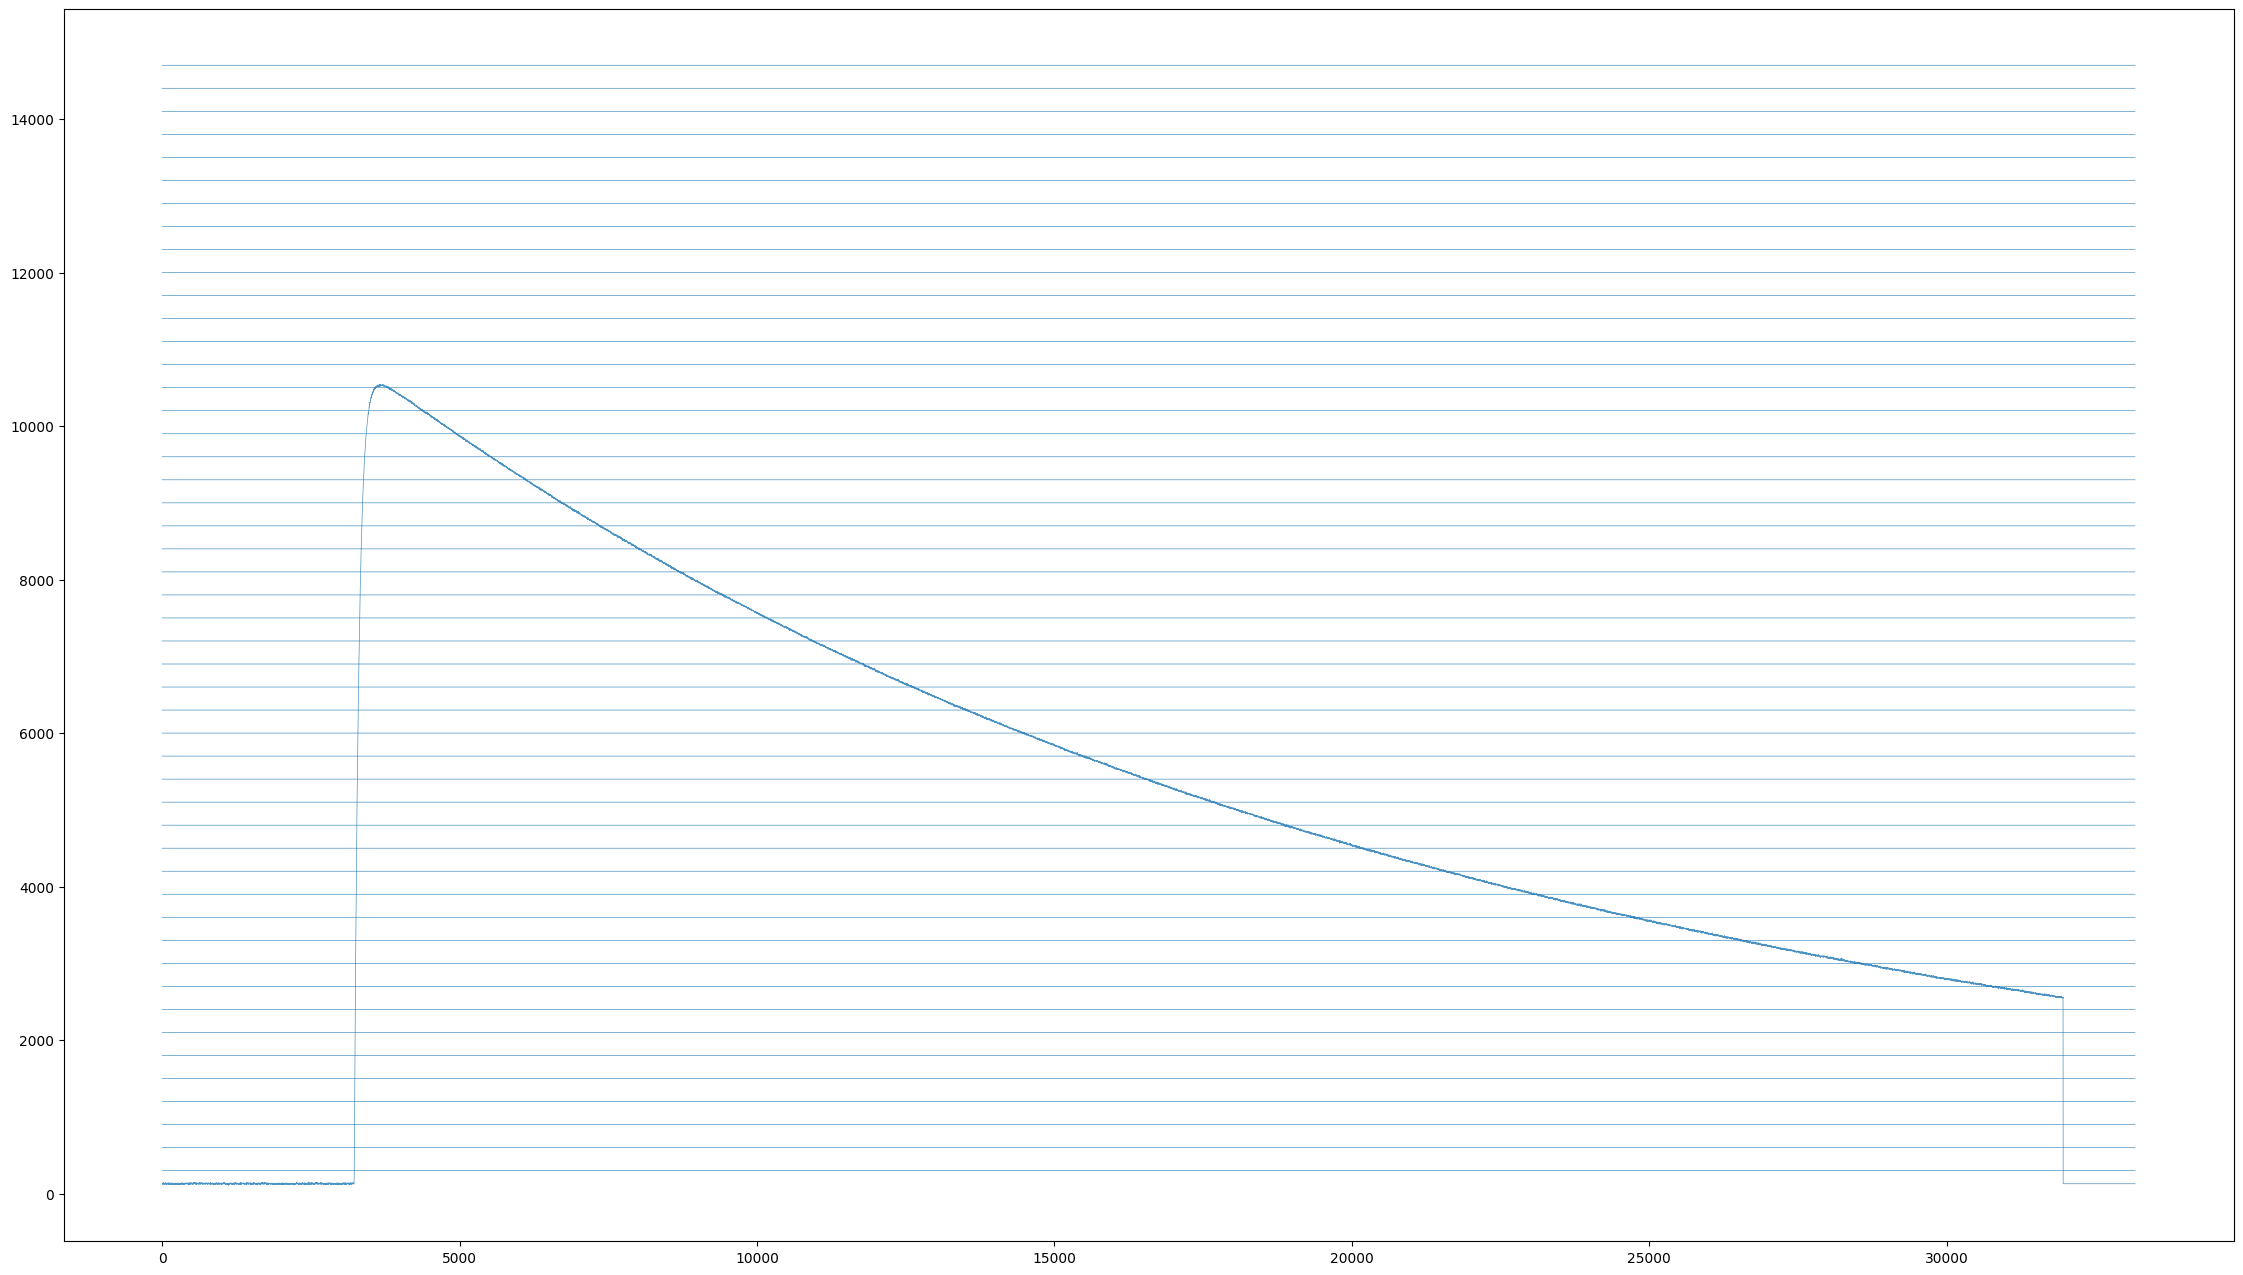

In [4]:
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

template_path = './plugins/event_rqs/default_templates.npy'

template = np.load(template_path, allow_pickle=True)


# change this to choose another event if the one below is a bad one by chance
i = 8

plt.figure(figsize=(28,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel

event = fit_results[i]

# plotting two-template fits in the vacuum channels
for i_vac, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.SUBMERGED)):
    if i_vac != 0:
        continue 
    fit = event['submerged_channel_uv_amplitude'][i_vac] * np.roll(template, 0)
    x = np.arange(len(template))
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, alpha=0.8, color='C1')



plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Apply MMC readout on silent traces')
plt.savefig('raw_traces_on_silent_plot.png', dpi=300, bbox_inches='tight')
plt.show()